In [1]:
import random
import numpy as np
import torch
from DatasetLidarCameraProper import DatasetLidarCameraKittiOdometry
import matplotlib.pyplot as plt

from utils import merge_inputs

In [2]:
_config = {
    'data_folder': './data/dataset_l_r_fix',
    'max_r': 1.0,
    'max_t': 0.1,
    'use_reflectance': False,
    'val_sequence': 0,
}
dataset_class = DatasetLidarCameraKittiOdometry

In [3]:
dataset_train = dataset_class(_config['data_folder'], max_r=_config['max_r'], max_t=_config['max_t'],
                                split='train', use_reflectance=_config['use_reflectance'],
                                val_sequence=_config['val_sequence'])
    

In [4]:
def _init_fn(worker_id, seed):
    seed = seed + worker_id + 1*100
    print(f"Init worker {worker_id} with seed {seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def init_fn(x): return _init_fn(x, 42)

In [5]:
dataloader = torch.utils.data.DataLoader(dataset=dataset_train,
        shuffle=True,
        batch_size=8,
        num_workers=0,
        worker_init_fn=init_fn,
        collate_fn=merge_inputs,
        drop_last=False,
        pin_memory=True
)

In [6]:
batch = next(iter(dataloader))

In [9]:
batch['point_cloud'][0].shape

torch.Size([4, 20000])

In [10]:
img = batch['rgb'][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


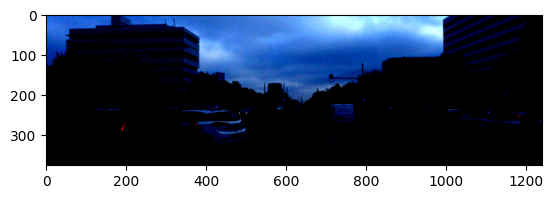

In [11]:
plt.imshow(img.permute(1,2,0))

In [12]:
img.shape

torch.Size([3, 376, 1241])

In [13]:
pc = batch['point_cloud'][0]
cam_intr = batch['calib'][0]

In [14]:
cam_intr

tensor([[957.5925,   0.0000, 959.3566],
        [  0.0000, 959.2311, 643.6836],
        [  0.0000,   0.0000,   1.0000]])

In [15]:
def get_2D_lidar_projection(pcl, cam_intrinsic):
    pcl_xyz = cam_intrinsic @ pcl.T
    pcl_xyz = pcl_xyz.T
    pcl_z = pcl_xyz[:, 2]
    pcl_xyz = pcl_xyz / (pcl_xyz[:, 2, None] + 1e-10)
    pcl_uv = pcl_xyz[:, :2]

    return pcl_uv, pcl_z

In [16]:
def lidar_project_depth(pc_rotated, cam_calib, img_shape):
    pc_rotated = pc_rotated[:3, :].detach().cpu().numpy()
    cam_intrinsic = cam_calib.numpy()
    pcl_uv, pcl_z = get_2D_lidar_projection(pc_rotated.T, cam_intrinsic)
    mask = (pcl_uv[:, 0] > 0) & (pcl_uv[:, 0] < img_shape[1]) & (pcl_uv[:, 1] > 0) & (
            pcl_uv[:, 1] < img_shape[0]) & (pcl_z > 0)
    pcl_uv = pcl_uv[mask]
    pcl_z = pcl_z[mask]
    pcl_uv = pcl_uv.astype(np.uint32)
    pcl_z = pcl_z.reshape(-1, 1)
    depth_img = np.zeros((img_shape[0], img_shape[1], 1))
    depth_img[pcl_uv[:, 1], pcl_uv[:, 0]] = pcl_z
    depth_img = torch.from_numpy(depth_img.astype(np.float32))
    depth_img = depth_img.cuda()
    depth_img = depth_img.permute(2, 0, 1)

    return depth_img, pcl_uv

In [17]:
def plot_3d(x, y, z):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(x, y, z)
    plt.show()

def plot_both(rgb, lidar):
    rgb = rgb.detach().cpu()
    lidar = lidar.detach().cpu()

    f, ax = plt.subplots(2)
    ax[0].imshow(rgb.permute(1,2,0))
    ax[1].imshow(lidar[0])

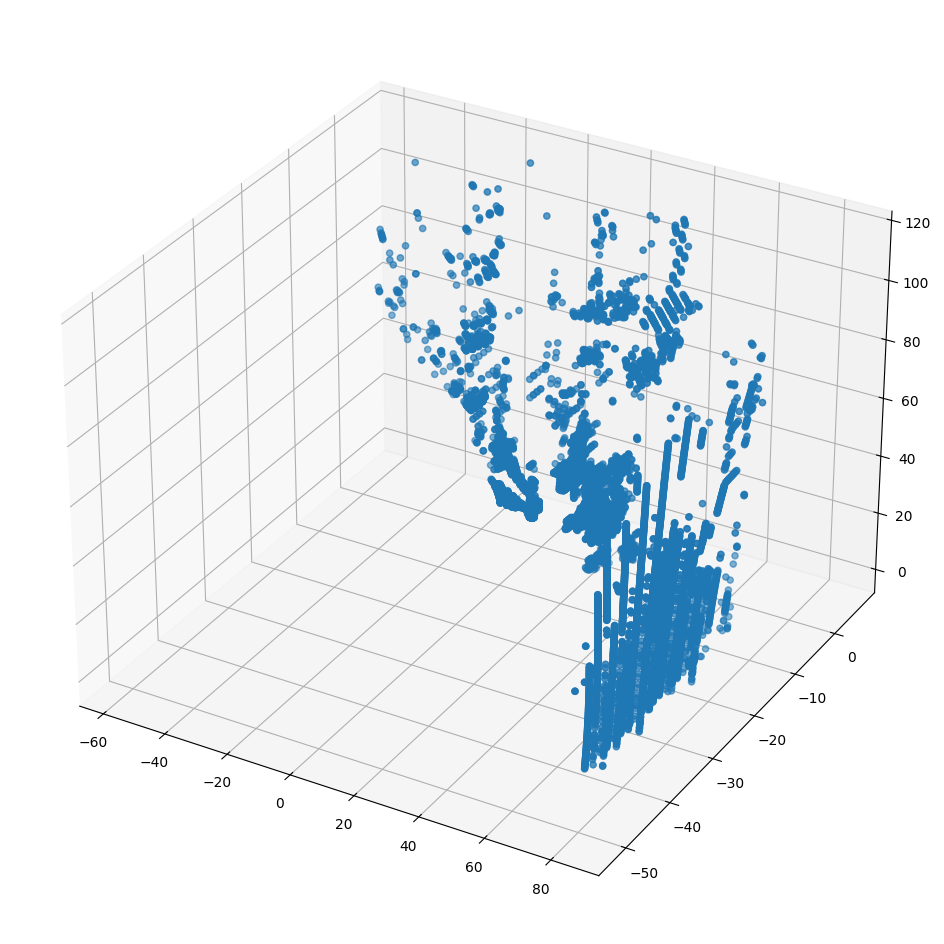

In [20]:
plot_3d(pc[0], pc[1], pc[2])

In [21]:
pc.shape

torch.Size([4, 20000])

In [22]:
pc_uv, pc_z = get_2D_lidar_projection(pc[:3].T, cam_intr)

In [23]:
pc_uv.shape

torch.Size([20000, 2])

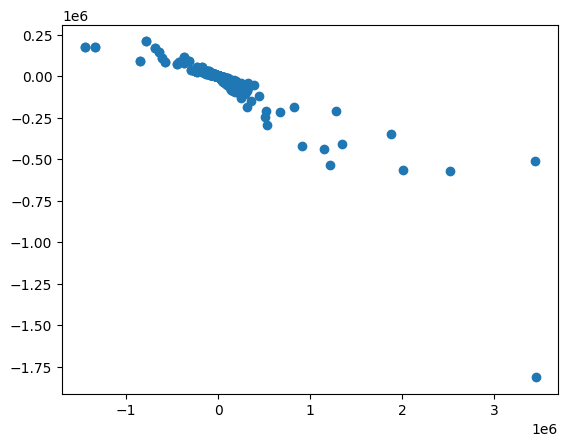

In [24]:
plt.scatter(pc_uv.T[0], pc_uv.T[1])

In [32]:
cam_intr

tensor([[957.5925,   0.0000, 959.3566],
        [  0.0000, 959.2311, 643.6836],
        [  0.0000,   0.0000,   1.0000]])

In [10]:
######################################################

In [39]:
from torchvision import transforms as T

In [50]:
def plot_img(img):
    plt.imshow(img.permute(1,2,0))

In [52]:
image_shape = img.shape[1:]
image_shape

torch.Size([1208, 1920])

In [66]:
transform =  T.Compose([
    T.CenterCrop((581, 1920)),
    T.Resize((376, 1241))
])

/home/yasin/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


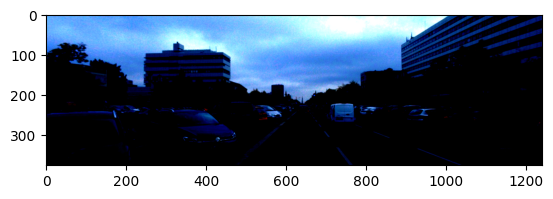

In [67]:
plot_img(transform(img))

In [20]:
pc_gt = np.fromfile('./data/dataset_l_r_fix/sequences/00/velodyne/000000.bin')